In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 1.6 MB/s eta 0:00:00


In [2]:
import FinanceDataReader as fdr

# 삼성전자

In [3]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
#df = fdr.DataReader('005930', '2023-01-01', '2024-12-31')
#df.tail

<bound method NDFrame.tail of              Open   High    Low  Close    Volume    Change
Date                                                      
2023-01-02  55500  56100  55200  55500  10031448  0.003617
2023-01-03  55400  56000  54500  55400  13547030 -0.001802
2023-01-04  55700  58000  55600  57800  20188071  0.043321
2023-01-05  58200  58800  57600  58200  15682826  0.006920
2023-01-06  58300  59400  57900  59000  17334989  0.013746
...           ...    ...    ...    ...       ...       ...
2024-07-11  88500  88800  86700  87600  24677608 -0.002278
2024-07-12  85900  86100  84100  84400  26344386 -0.036530
2024-07-15  84700  87300  84100  86700  25193080  0.027251
2024-07-16  86900  88000  86700  87700  16166688  0.011534
2024-07-17  87100  88000  86400  86700  17745561 -0.011403

[379 rows x 6 columns]>

In [27]:
#빅히트(하이브)로 변경

df = fdr.DataReader('352820', '2023-06-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close  Volume    Change
Date                                                        
2023-06-01  274000  283000  272500  277500  273680  0.012774
2023-06-02  276000  278000  263500  270000  448545 -0.027027
2023-06-05  270000  271000  264000  265000  165535 -0.018519
2023-06-07  265000  272000  265000  269000  174858  0.015094
2023-06-08  267500  271000  265000  268000  151260 -0.003717
...            ...     ...     ...     ...     ...       ...
2024-07-11  191000  191300  188100  190100  297369 -0.002100
2024-07-12  189700  193000  189200  189700  194203 -0.002104
2024-07-15  190500  191700  188000  188200  153404 -0.007907
2024-07-16  188300  188300  185900  186300  148849 -0.010096
2024-07-17  185600  186500  182400  182500  259979 -0.020397

[277 rows x 6 columns]>

# 분석 코드

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

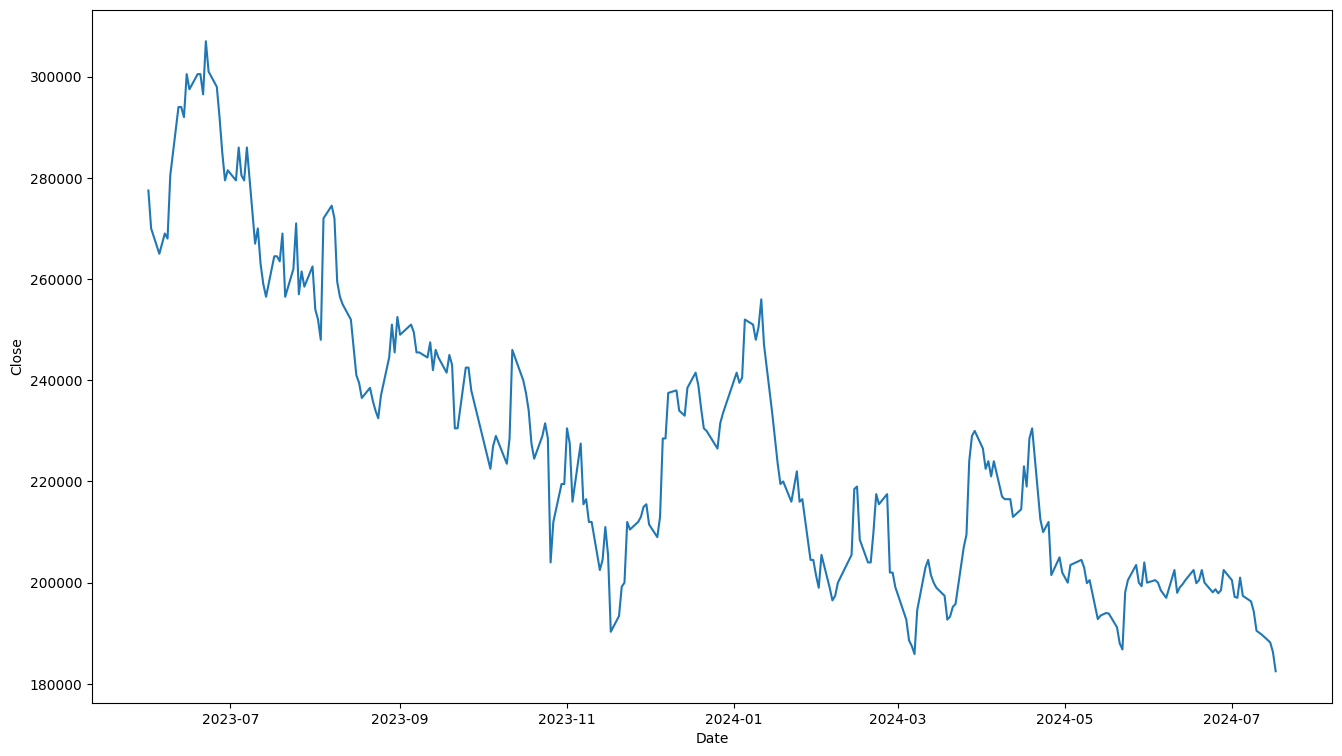

In [30]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [31]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [32]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [33]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([72, 5, 4]) torch.Size([72, 1])


In [34]:
x_train_seq

tensor([[[0.7282, 0.7659, 0.7794, 0.0539],
         [0.7446, 0.7262, 0.7016, 0.1022],
         [0.6952, 0.6706, 0.7059, 0.0240],
         [0.6540, 0.6786, 0.7145, 0.0265],
         [0.6746, 0.6706, 0.7145, 0.0200]],

        [[0.7446, 0.7262, 0.7016, 0.1022],
         [0.6952, 0.6706, 0.7059, 0.0240],
         [0.6540, 0.6786, 0.7145, 0.0265],
         [0.6746, 0.6706, 0.7145, 0.0200],
         [0.6993, 0.7937, 0.7491, 0.0972]],

        [[0.6952, 0.6706, 0.7059, 0.0240],
         [0.6540, 0.6786, 0.7145, 0.0265],
         [0.6746, 0.6706, 0.7145, 0.0200],
         [0.6993, 0.7937, 0.7491, 0.0972],
         [0.8147, 0.8611, 0.8529, 0.0895]],

        ...,

        [[0.0791, 0.1008, 0.1047, 0.0287],
         [0.0692, 0.0802, 0.0830, 0.0232],
         [0.0840, 0.1746, 0.1159, 0.0798],
         [0.1763, 0.2103, 0.1869, 0.0648],
         [0.2216, 0.3333, 0.2517, 0.2216]],

        [[0.0692, 0.0802, 0.0830, 0.0232],
         [0.0840, 0.1746, 0.1159, 0.0798],
         [0.1763, 0.2103, 0.1869

In [35]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

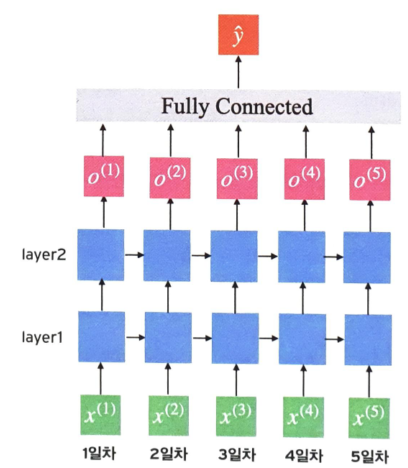

In [36]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [37]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [38]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [39]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [40]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0442
[epoch : 10] loss: 0.0080
[epoch : 20] loss: 0.0070
[epoch : 30] loss: 0.0057
[epoch : 40] loss: 0.0052


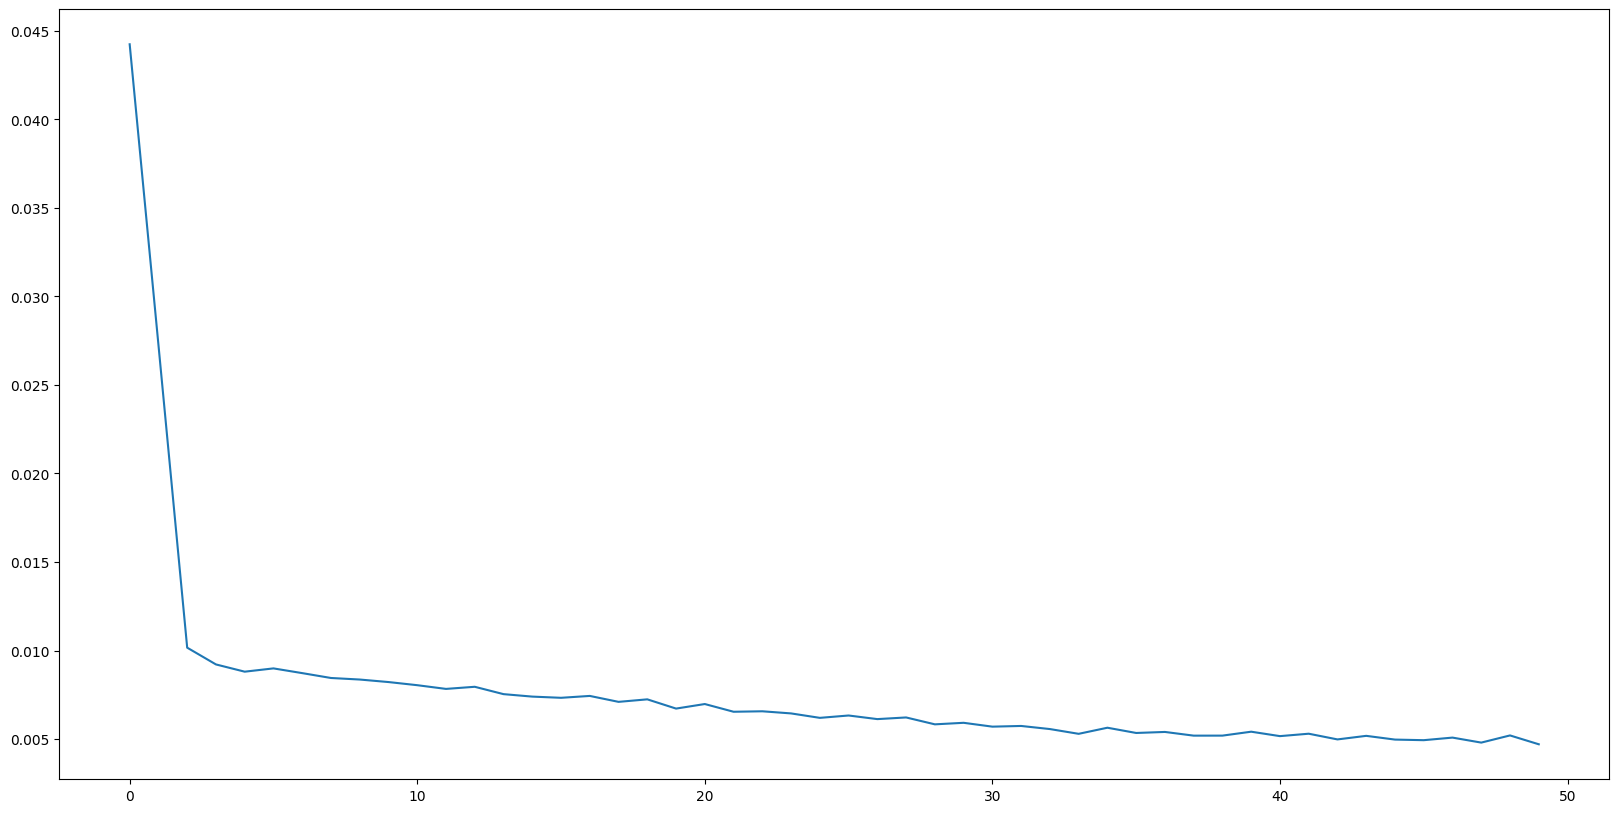

In [41]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [42]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

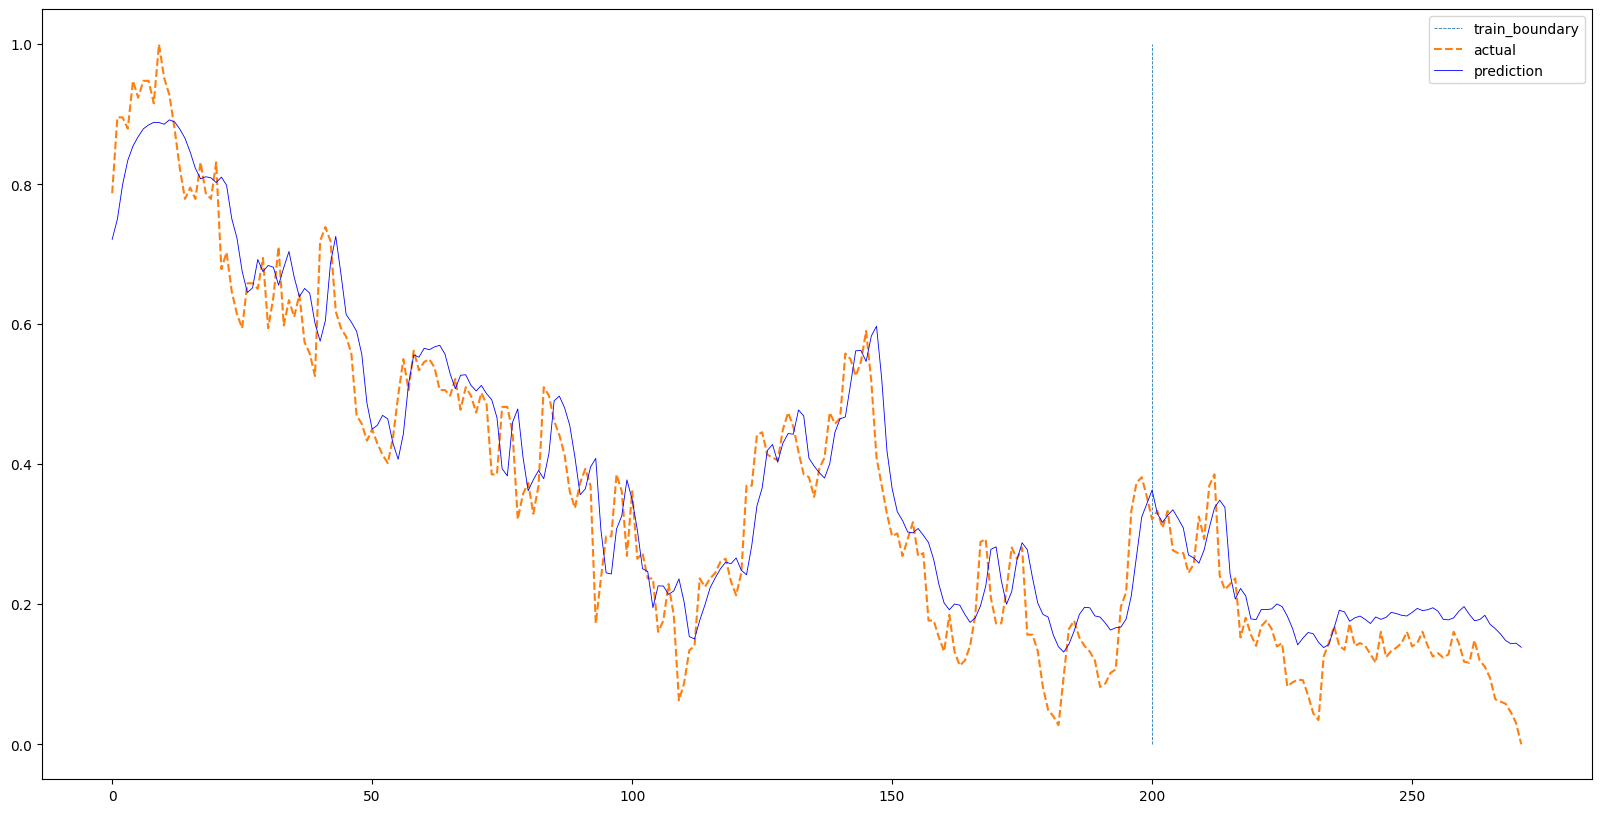

In [43]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [44]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [45]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [46]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [47]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [48]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.2831
[epoch: 10] loss: 0.0088
[epoch: 20] loss: 0.0084
[epoch: 30] loss: 0.0078
[epoch: 40] loss: 0.0073


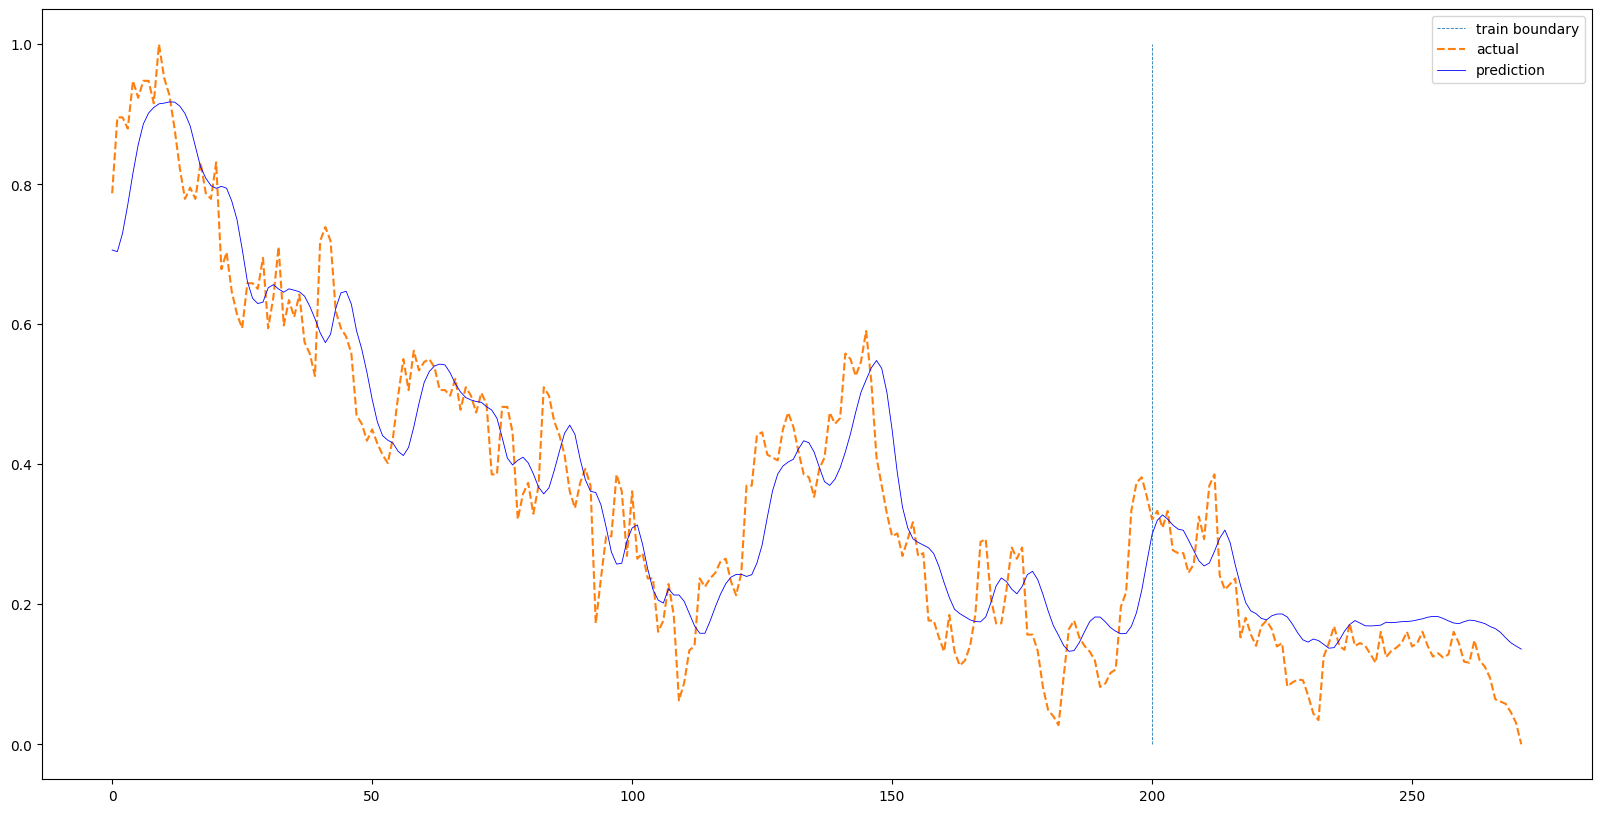

In [49]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [26]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2023-01-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close   Volume    Change
Date                                                         
2023-01-02  154000  161000  154000  157000  1132256  0.039735
2023-01-03  158500  160500  156000  159000   787752  0.012739
2023-01-04  157500  161000  157500  160500   463444  0.009434
2023-01-05  161000  161500  158000  159000   577152 -0.009346
2023-01-06  157500  161500  157500  159500   502420  0.003145
...            ...     ...     ...     ...      ...       ...
2024-07-11  277000  278500  274500  278500   653458  0.014572
2024-07-12  277500  278500  268000  271500   666813 -0.025135
2024-07-15  273000  273500  267500  268500   541442 -0.011050
2024-07-16  270500  276000  270000  274500   552065  0.022346
2024-07-17  275500  275500  268000  268500   509678 -0.021858

[379 rows x 6 columns]>